<a href="https://colab.research.google.com/github/upadhyayprakash/eva4/blob/master/S10/EVA4_Session_10_CIFAR10_RESNet18_SGD_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Session-10 Assignment**

1. Pick your last code and Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)
2. Use this repo: https://github.com/davidtvs/pytorch-lr-finder (Links to an external site.) 
  - Move LR Finder code to your modules
  - Implement LR Finder (for SGD, not for ADAM)
  - Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau (Links to an external site.)
3. Find best LR to train your model
4. Use SDG with Momentum
5. Train for 50 Epochs. 
6. Show Training and Test Accuracy curves
7. Target 88% Accuracy.
8. Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label. Submit
 

### **These are the questions in S10-Assignment-Solution**

- Paste your S10 Assignment's GitHub Link - 500PTS
- Paste the link or upload Training and Test Curves (there should only be 1 graph)- 100PTS
- What is the training accuracy of your model? - 150PTS
- Share the link or upload an image of 25 misclassified images with GradCam results on top of them- 250PTS

#### **RESULT**
GitHub Source: https://github.com/upadhyayprakash/eva4/tree/master/S10

#### **Summary**

| Metric          | Values         |
| --------------- | -------------- |
| Network Arch.   | **RESNET-18**  |
| # of Epochs     | **50**         |
| # of Parameters | **11,173,962** |
| Final Accuracy  | **__.__%**    |
| Augmentation(Using ALBUMENTATION)    | **CUTOUT**, HorizFlip, ShiftScaleRotate, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness |
| GradCam         | To visualize activation map of **25** mis-classified samples |
| Optimizer | SGD with Momentum |
| Scheduler | ReduceLROnPlateau |
| LR Finder | Averaged 3 LRs for smoother learning Rate |

#### Loading the Libraries

In [0]:
# Setting up the module import directory
import sys
sys.path.append('/home/prakash/Prakash/EVA4/Session-10/Notebooks')

In [0]:
# for inline graph plotting
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, LambdaLR # LR Scheduler
from torchsummary import summary

#### Checking if GPU(CUDA) is supported

In [3]:
cuda = torch.cuda.is_available() # returns True/False
print('GPU Available?', cuda)

# initiate the Network
device = torch.device("cuda" if cuda else "cpu")

GPU Available? True


#### Loading and Transforming the CIFAR10 Dataset

In [4]:
# MODULES: Train and Test Data Loaders modules
import data_loader
trainloader = data_loader.getTrainLoader('CIFAR10')
testloader = data_loader.getTestLoader('CIFAR10')

classes = data_loader.getClasses('CIFAR10')

print('Classes: ')
print(classes)

GPU Available? True
Files already downloaded and verified
Files already downloaded and verified
Classes: 
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#### Visualize the training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch Grid


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

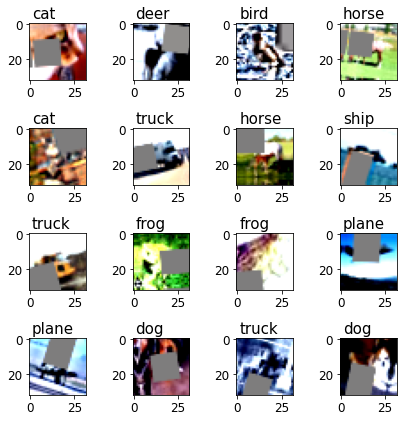

In [5]:
import visualize_data

visualize_data.visualize_batch(trainloader, classes)

### Creating the Network Object

In [6]:
# Loading the Network
# from network import Net
from models.resnet import ResNet18

net = ResNet18().to(device)
summary(net, input_size=(3, 32, 32)) # Network Summary

torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

### Define Loss Criterion, Optimizer

In [0]:
# define Loss Function, Optimizer and Step learning rate

loss_fun = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-2)

### LR Finder
**Reference**: https://github.com/davidtvs/pytorch-lr-finder

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()


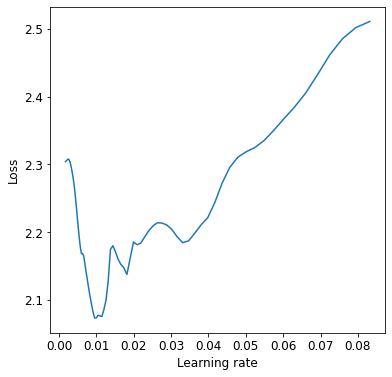

Initial LR using lr_finder():  0.01



Learning rate search finished. See the graph with {finder_name}.plot()


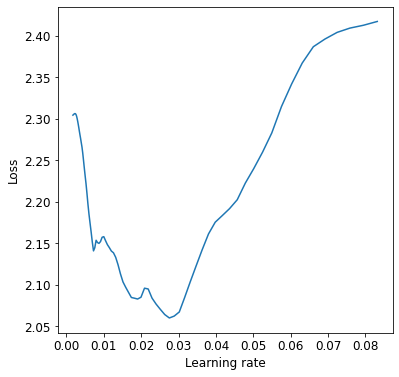

Initial LR using lr_finder():  0.027542287033381664



Learning rate search finished. See the graph with {finder_name}.plot()


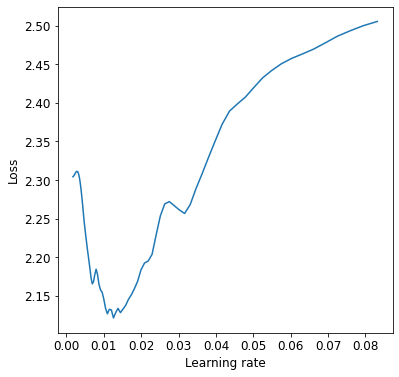

Initial LR using lr_finder():  0.012589254117941675
Learning Rate Finder after number of Trials:
[0.01, 0.027542287033381664, 0.012589254117941675]
New Learning Rate Suggested: 
0.017


In [8]:
import lr_utility
import statistics

lr_finder_trials = 3

min_loss_lr_arr = []
for idx in range(lr_finder_trials):
  lr_history = lr_utility.lr_finder(net, optimizer, loss_fun, trainloader, testloader)

  # Calculating the initial LR with minimum loss as per the lr_finder()
  min_loss = min(lr_history['loss'])
  min_loss_index = lr_history['loss'].index(min_loss)
  min_loss_lr = lr_history['lr'][min_loss_index]
  print('Initial LR using lr_finder(): ', min_loss_lr)
  min_loss_lr_arr.append(min_loss_lr)

print('Learning Rate Finder after number of Trials:')
print(min_loss_lr_arr)

# Avg of LRs found
min_loss_lr = statistics.mean(min_loss_lr_arr)
new_lr = round(min_loss_lr, 3)
print('New Learning Rate Suggested: ')
print(new_lr)

### Updating the Optimizer with new Learning Rate

In [12]:
# Changing the Optimizer with Updated Learning Rate
print('Optimizer BEFORE LRFinder:')
print(optimizer)
for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

print('\nOptimizer AFTER LRFinder:(Notice the LR change)')
print(optimizer)

Optimizer BEFORE LRFinder:
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.017
    momentum: 0.9
    nesterov: False
    weight_decay: 0.05
)

Optimizer AFTER LRFinder:(Notice the LR change)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.012
    momentum: 0.9
    nesterov: False
    weight_decay: 0.05
)


### Training Program

In [14]:
# Model Trainer
import model_trainer

# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, min_lr=1e-4)

EPOCHS = 50
# Training and Testing the model
traintestresult = model_trainer.fit_model(net, EPOCHS, device, trainloader, testloader, classes, loss_fun, optimizer, scheduler)
model = traintestresult['model']

EPOCH: 1
 [================================================================>]  Step: 175ms | Tot: 1m44s | Train Loss: 1.632 | Train Acc: 43.100% (21550/50000) 391/391 
 [================================================================>]  Step: 106ms | Tot: 6s467ms | Test Loss: 1.547 | Test Acc: 44.890% (4489/10000) 79/79 
EPOCH: 2
 [================================================================>]  Step: 174ms | Tot: 1m44s | Train Loss: 1.630 | Train Acc: 43.238% (21619/50000) 391/391 
 [================================================================>]  Step: 108ms | Tot: 6s463ms | Test Loss: 2.156 | Test Acc: 26.780% (2678/10000) 79/79 
EPOCH: 3
 [================================================================>]  Step: 165ms | Tot: 1m40s | Train Loss: 1.621 | Train Acc: 43.410% (21705/50000) 391/391 
 [================================================================>]  Step: 98ms | Tot: 6s2ms | Test Loss: 1.568 | Test Acc: 42.650% (4265/10000) 79/79 
EPOCH: 4
 [====================

### Train/Test Visualization
Visualizing Training and Testing Results

58
58


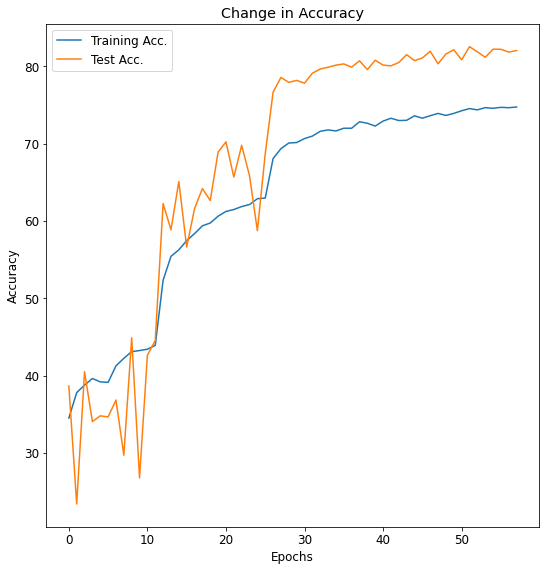

In [15]:
# extract the training/testing metrics
val_acc = traintestresult['val_acc']
val_loss = traintestresult['val_loss']
train_acc = traintestresult['train_acc']
train_loss = traintestresult['train_loss']

# visualize the training/testing stats
visualize_data.visualize_train_test_acc(train_acc, val_acc)

### Class-wise Evaluation Result

Accuracy of plane : 95 %
Accuracy of   car : 100 %
Accuracy of  bird : 67 %
Accuracy of   cat : 30 %
Accuracy of  deer : 80 %
Accuracy of   dog : 58 %
Accuracy of  frog : 93 %
Accuracy of horse : 97 %
Accuracy of  ship : 95 %
Accuracy of truck : 90 %


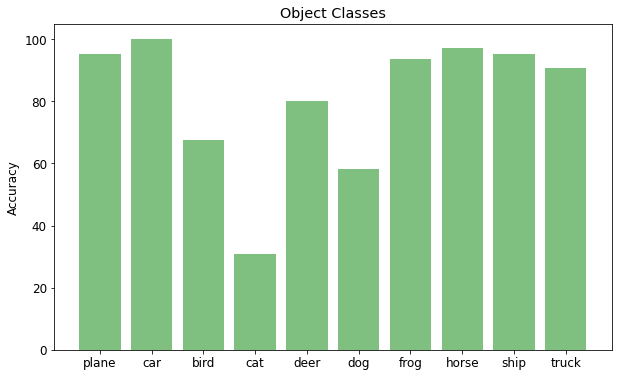

In [16]:
import class_wise_results

class_wise_results.show_class_wise_results(model, testloader, device, classes)

### Plotting Mis-classified Sample Objects

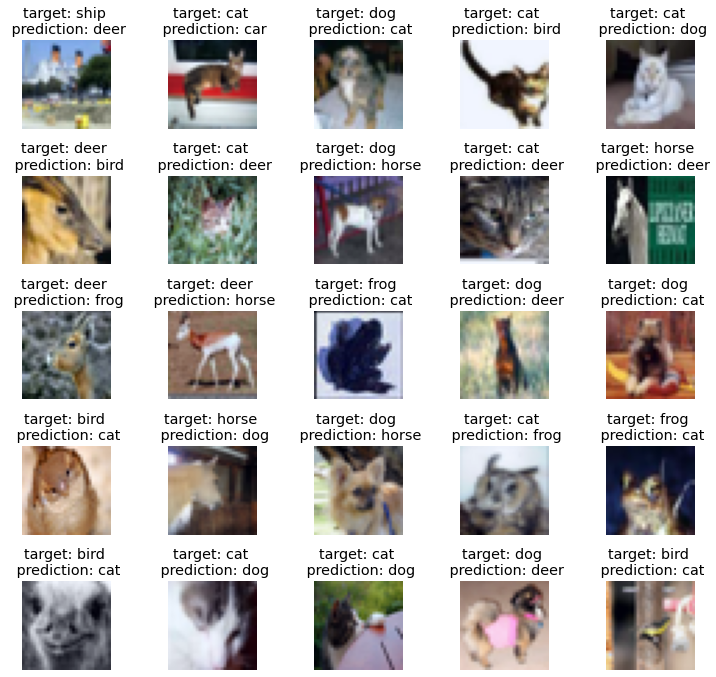

In [17]:
import misclassifieds
# Plotting mis-classified test
failed_samples = misclassifieds.plot_mis_classified_objects(model, device, classes, testloader)

### GradCam Visualization
Visualizing the failed test samples using GradCAM and GradCAM++

/home/prakash/anaconda3/envs/eva4/lib/python3.8/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


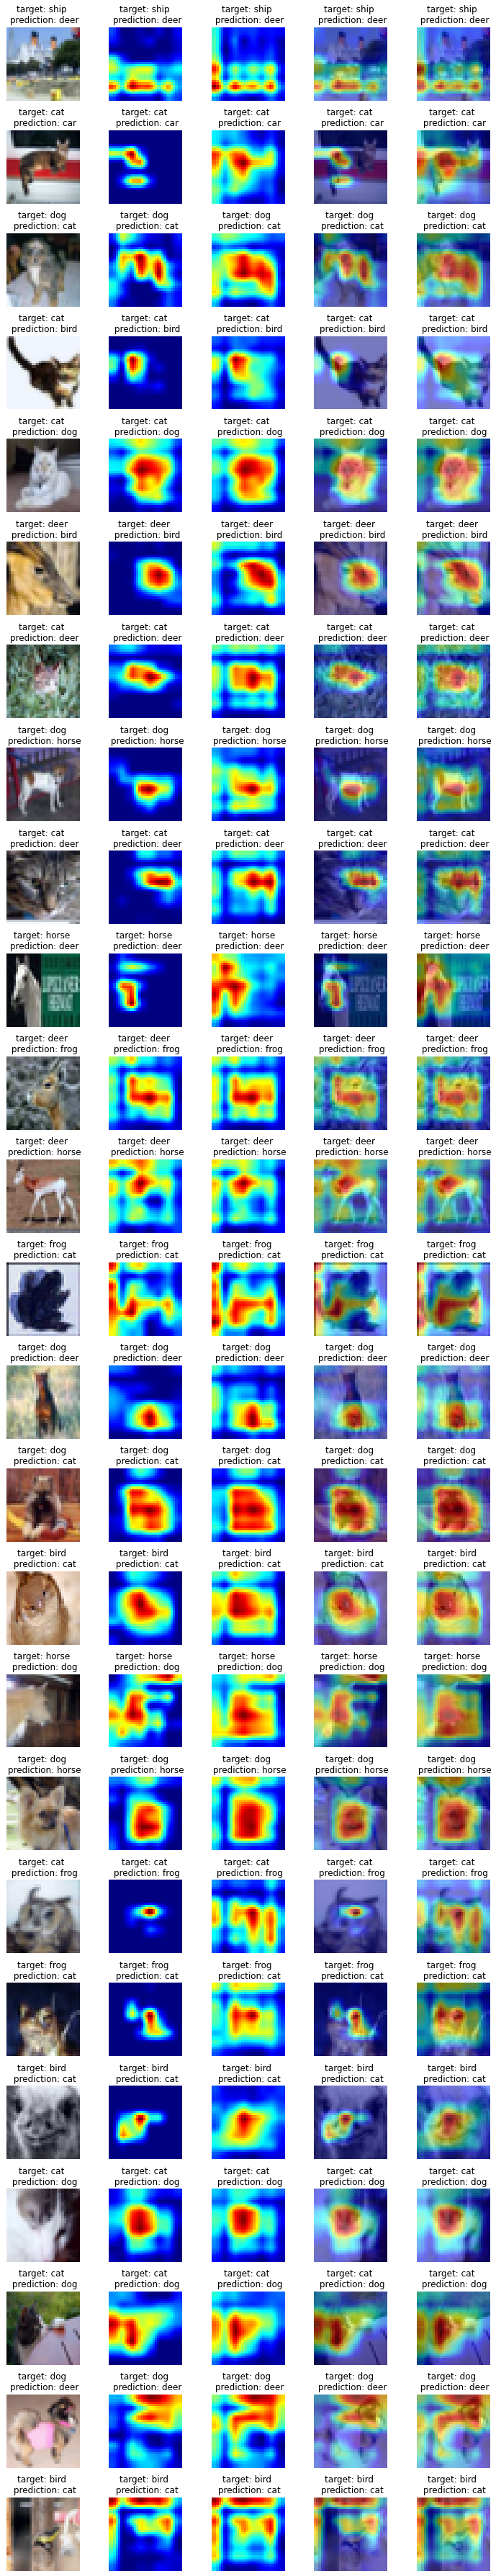

In [18]:
# Visualize the GradCam 
from grad_cam_vis import visualize_grad_cam
%matplotlib inline

# Visualizing the GradCAM in the format of:
# Original Image, It's heatmap, heatmap of GradCAM++, Final Result, Final Result using GradCAM++
visualize_grad_cam(model, failed_samples, classes)